# **Generación de Datos para la Ecuación de Onda**

En este código se construyen los conjuntos de entrenamiento y testeo para la ecuación de onda, resolviendo a partir de una condición inicial y retornando su solución en el tiempo $T$.


In [1]:
# Importar Librerías
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from neuralop.losses.finite_diff import central_diff_2d


start_time= time.time()

In [12]:
# Definición de parámetros

# Espaciales
Lx, Ly = np.pi, np.pi
nx, ny = 32, 32

X = torch.linspace(-Lx, Lx, nx).repeat(ny, 1).T
Y = torch.linspace(-Ly, Ly, ny).repeat(nx, 1)
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

# Temporales
dt = 1e-2                       
N = 500                       
nt = N + 1                     
T = dt * nt                 

# Velocidad de Propagación
c = 2

# Tamaño del Batch
batch_size = 32

In [13]:
# Crear directorio para guardar datos
data_dir = Path("../data/wave_data")
data_dir.mkdir(parents=True, exist_ok=True)

## **Solver usando Diferencias Finitas**

Queremos resolver la ecuación de onda:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \Delta u$$

la cual describe la propagación de ondas en un medio continuo, como vibraciones en una cuerda, presión en el aire o pulsos en una membrana elástica.

En particular:
- $u(x, y, t)$ : **desplazamiento del medio** en el tiempo $t$
- $c$ : **velocidad de propagación** de la onda $(\text{m/s})$

Se resolverá la ecuación de onda con una condición inicial tipo pulso gaussiano aleatorio:

$$u_0(x, y) = \mu \cdot \exp\left(-\frac{(x - x_c)^2 + (y - y_c)^2}{\sigma^2}\right)$$

donde:

-  $\mu \sim |U([1, 5])|$ es la amplitud aleatoria del pulso.
- $(x_c, y_c) \sim U([-\pi, \pi]) \times U([-\pi, \pi])$ representa el centro aleatorio del pulso gaussiano en el dominio.
- $\sigma^2 = 0.1$ es la varianza fija del pulso.


sobre el dominio $\mathbb{T}^2 = [-\pi, \pi]^2$, el toro de dimensión 2 (condiciones de borde periódicas en las aristas paralelas)

In [14]:
# Resolver la EDP y Retornar la Solución en el Tiempo Final
def solve_wave_equation(u0_batch, c, dt, dx, dy, nt):
    batch_size, nx, ny = u0_batch.shape
    u_evolution = torch.zeros(batch_size, nt, nx, ny)

    u_nm1 = u0_batch.clone()
    u_n = u0_batch.clone()

    u_evolution[:, 0, :, :] = u_n

    for n in range(1, nt):
        u_x, u_y = central_diff_2d(u_n, [dx, dy])
        u_xx, _ = central_diff_2d(u_x, [dx, dy])
        _, u_yy = central_diff_2d(u_y, [dx, dy])

        u_np1 = 2 * u_n - u_nm1 + ((c * dt) ** 2) * (u_xx + u_yy)

        u_nm1 = u_n
        u_n = u_np1

        u_evolution[:, n, :, :] = u_np1

    return u_evolution[:, -1, :, :]

## **Generación de Datos de Entrenamiento**

Para construir los conjuntos de entrenamiento y test debemos generar pares $a_j$ y $u_j$ con la estructura adecuada. Consideraremos 1024 pares de entrenamiento y 192 pares de test con paquetes de tamaño 32 (*batch_size*)

En este caso $a_j$ será la condición inicial aleatoria definida anteriomente sobre una malla de $(nx,ny)$ puntos y $u_j$ es la solución de la EDP en el tiempo final $T$.

In [15]:
N_train = 1024

a = torch.zeros(N_train, nx, ny)  
u = torch.zeros(N_train, nx, ny) 

i = 0
for j in range(N_train // batch_size):
    print(f"Batch {j}/{N_train // batch_size}")
    
    # Condición inicial gaussiana
    mu = torch.tensor(np.abs(np.random.uniform(1, 5, batch_size)),
                       dtype=torch.float32).view(-1, 1, 1) 
    x_center = torch.tensor(np.random.uniform(-Lx+1, Lx-1, batch_size),
                             dtype=torch.float32).view(-1, 1, 1) 
    y_center = torch.tensor(np.random.uniform(-Ly+1, Ly-1, batch_size),
                             dtype=torch.float32).view(-1, 1, 1)
    X_exp, Y_exp = X.unsqueeze(0), Y.unsqueeze(0)
    gauss = torch.exp(-((X_exp - x_center) ** 2 + (Y_exp - y_center) ** 2) / 0.3)
    u0 = mu * gauss 

    u_batch = solve_wave_equation(u0, c, dt, dx, dy, nt)

    a[i:(i + batch_size), ...] = u0
    u[i:(i + batch_size), ...] = u_batch
    i += batch_size

x_train = a 
y_train = u 

torch.save({"x": x_train, "y": y_train}, data_dir / f"onda_train_{nx}.pt")
print(f"Datos de entrenamiento guardados en '{data_dir / f'onda_train_{nx}.pt'}'")

Batch 0/32
Batch 1/32
Batch 2/32
Batch 3/32
Batch 4/32
Batch 5/32
Batch 6/32
Batch 7/32
Batch 8/32
Batch 9/32
Batch 10/32
Batch 11/32
Batch 12/32
Batch 13/32
Batch 14/32
Batch 15/32
Batch 16/32
Batch 17/32
Batch 18/32
Batch 19/32
Batch 20/32
Batch 21/32
Batch 22/32
Batch 23/32
Batch 24/32
Batch 25/32
Batch 26/32
Batch 27/32
Batch 28/32
Batch 29/32
Batch 30/32
Batch 31/32
Datos de entrenamiento guardados en '..\data\wave_data\onda_train_32.pt'


## **Generación de Datos de Testeo**

In [16]:
N_test = 192

a = torch.zeros(N_test, nx, ny)  
u = torch.zeros(N_test, nx, ny) 

i = 0

for j in range(N_test//batch_size):
    print(f"Batch {j}/{N_train // batch_size}")
    
    # Condición inicial gaussiana
    mu = torch.tensor(np.abs(np.random.uniform(1, 5, batch_size)),
                       dtype=torch.float32).view(-1, 1, 1) 
    x_center = torch.tensor(np.random.uniform(-Lx+1, Lx-1, batch_size),
                             dtype=torch.float32).view(-1, 1, 1) 
    y_center = torch.tensor(np.random.uniform(-Ly+1, Ly-1, batch_size),
                             dtype=torch.float32).view(-1, 1, 1)
    X_exp, Y_exp = X.unsqueeze(0), Y.unsqueeze(0)
    gauss = torch.exp(-((X_exp - x_center) ** 2 + (Y_exp - y_center) ** 2) / 0.3)
    u0 = mu * gauss 

    u_batch = solve_wave_equation(u0, c, dt, dx, dy, nt)

    a[i:(i + batch_size), ...] = u0
    u[i:(i + batch_size), ...] = u_batch
    i += batch_size

x_train = a 
y_train = u

torch.save({"x": x_train, "y": y_train}, data_dir / f"onda_test_{nx}.pt")
print(f"Datos de entrenamiento guardados en '{data_dir / f'onda_test_{nx}.pt'}'")


Batch 0/32
Batch 1/32
Batch 2/32
Batch 3/32
Batch 4/32
Batch 5/32
Datos de entrenamiento guardados en '..\data\wave_data\onda_test_32.pt'


In [17]:
end_time = time.time()
print("El tiempo de ejecución para crear los datasets fue de : ", end_time - start_time, " segundos")

El tiempo de ejecución para crear los datasets fue de :  908.2095651626587  segundos


## **Visualización**

A continuación se presenta un código para generar un archivo en formato GIF que muestra la evolución de la solución.

In [8]:
def solve_wave_equation(u0_batch, c, dt, dx, dy, nt):
    batch_size, nx, ny = u0_batch.shape
    u_evolution = torch.zeros(batch_size, nt, nx, ny)

    u_nm1 = u0_batch.clone()
    u_n = u0_batch.clone()

    u_evolution[:, 0, :, :] = u_n

    for n in range(1, nt):
        u_x, u_y = central_diff_2d(u_n, [dx, dy])
        u_xx, _ = central_diff_2d(u_x, [dx, dy])
        _, u_yy = central_diff_2d(u_y, [dx, dy])

        u_np1 = 2 * u_n - u_nm1 + ((c * dt) ** 2) * (u_xx + u_yy)

        u_nm1 = u_n
        u_n = u_np1

        u_evolution[:, n, :, :] = u_np1

    return u_evolution


# Espaciales
Lx, Ly = np.pi, np.pi
nx, ny = 128, 128
X = torch.linspace(-Lx, Lx, nx).repeat(ny, 1).T
Y = torch.linspace(-Ly, Ly, ny).repeat(nx, 1)
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

# Temporales
dt = 1e-2
N = 500
nt = N
T = dt * nt

# Velocidad de propagación
c = 2

# Tamaño del batch
batch_size = 1

# Condición inicial gaussiana
mu = torch.tensor(np.abs(np.random.uniform(1, 5, batch_size)),
                  dtype=torch.float32).view(-1, 1, 1) 
x_center = torch.tensor(np.random.uniform(-Lx+1, Lx-1, batch_size),
                        dtype=torch.float32).view(-1, 1, 1) 
y_center = torch.tensor(np.random.uniform(-Ly+1, Ly-1, batch_size),
                        dtype=torch.float32).view(-1, 1, 1)
X_exp, Y_exp = X.unsqueeze(0), Y.unsqueeze(0)
gauss = torch.exp(-((X_exp - x_center) ** 2 + (Y_exp - y_center) ** 2) / 0.3)
u0 = mu * gauss 

# Resolver EDP
u_evolution = solve_wave_equation(u0, c, dt, dx, dy, nt)

u_batch = u_evolution[0]
nt, ny, nx = u_batch.shape

# Crear grilla de coordenadas (X, Y) para superficie
x = np.linspace(-Lx, Lx, nx)
y = np.linspace(-Ly, Ly, ny)
X, Y = np.meshgrid(x, y)

# Crear figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Función de actualización
def update(frame):
    ax.clear()
    ax.set_title(f"t = {frame * dt:.2f} s")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("u")

    ax.set_zlim(-1.1, 1.1)
    return ax.plot_surface(X, Y, u_batch[frame], cmap='viridis')

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=nt, interval=30)
ani.save("wave_equation_solution.gif", writer=animation.PillowWriter(fps=30))
plt.close(fig)


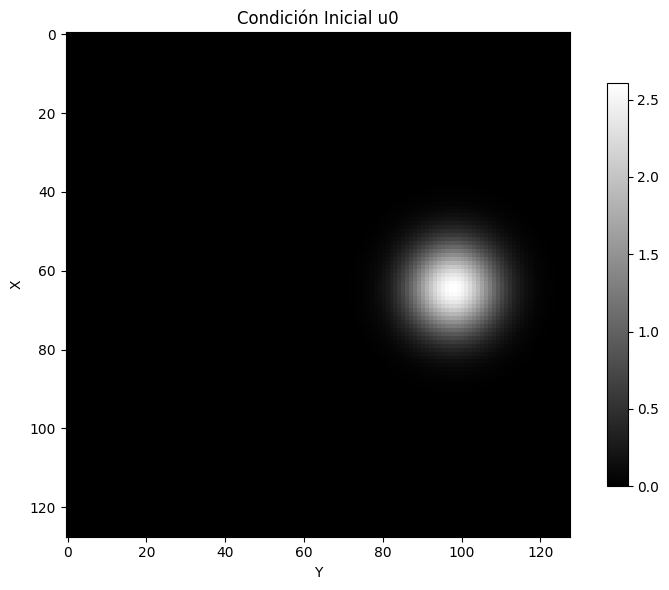

In [9]:
# Visualizar Condición Inicial
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

im = ax.imshow(u0[0].clone().numpy(), cmap="gray")

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_title('Condición Inicial u0')


fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

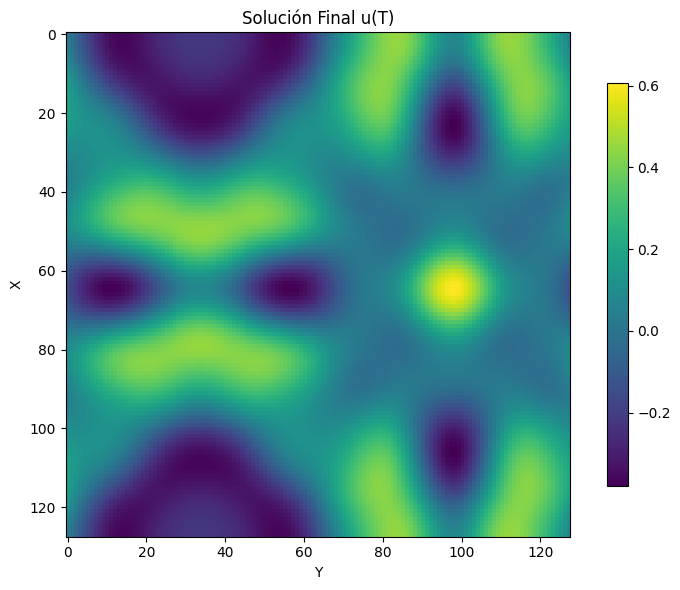

In [10]:
# Visualización Solución Final
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

im = ax.imshow(u_batch[-1].clone().numpy(), cmap="viridis")

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_title('Solución Final u(T)')

fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()